In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import joblib


In [2]:
# Chargement du dataset
df = pd.read_csv(r"C:\Users\pc\Desktop\ELBACHARIOussama-Mehiyddineabdelhakim)\Data\Dataset_Abandon_Scolaire.csv")
df.head()


,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Situation_familiale,Abandon
0,21,Femme,89.585023,2,15.826896,Enfants à charge,0
1,20,Homme,70.713068,3,12.829358,Célibataire,0
2,22,Femme,82.122963,1,13.086319,Enfants à charge,0
3,24,Homme,87.408859,3,14.992032,Célibataire,0
4,20,Homme,86.470676,3,12.671649,Marié,0


In [4]:
df_ml = df.copy()
label_encoders = {}
for col in ['Sexe', 'Situation_familiale']:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col])
    label_encoders[col] = le

X = df_ml.drop("Abandon", axis=1)
y = df_ml["Abandon"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Variance expliquée par PCA :", pca.explained_variance_ratio_)


Variance expliquée par PCA : [0.42962901 0.1725405 ]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [7]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



=== Logistic Regression ===
[[367   3]
 [ 18  12]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       370
           1       0.80      0.40      0.53        30

    accuracy                           0.95       400
   macro avg       0.88      0.70      0.75       400
weighted avg       0.94      0.95      0.94       400


=== KNN ===
[[363   7]
 [ 13  17]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       370
           1       0.71      0.57      0.63        30

    accuracy                           0.95       400
   macro avg       0.84      0.77      0.80       400
weighted avg       0.95      0.95      0.95       400


=== Decision Tree ===
[[352  18]
 [ 14  16]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       370
           1       0.47      0.53      0.50        30

    accuracy                           0.92     

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_



In [10]:
import joblib

joblib.dump(best_model, "best_model_knn.pkl")


['best_model_knn.pkl']

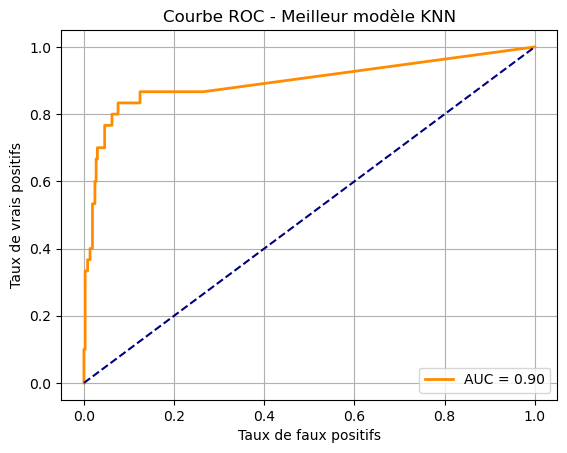

In [11]:
y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC - Meilleur modèle KNN")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_curve_knn.png")
plt.show()


In [14]:
y_pred_best = best_model.predict(X_test)



In [15]:
report_dict = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("rapport_classification_knn.csv", index=True)
